# HilbertSort

---

Author: Rafael Zamora-Resendiz

## Overview
This project contains a Python implementation of sorting of points in Euclidean
space using Hilbert space-filling curves. Space filling curves are 1-dimensional
traversals of n-dimensional space where each point in a discrete space is visited
once. These family of curves have been heavily researched in the past of there
locality preserving properties and are especially useful for dimensionality reduction.

Here, we explore Hilbert's famous curve to establish an ordering to a set of points
in 3D space. The sorting of points along the traversal of the space filling curve allows
for efficient point cloud reduction using sequence-based averaging while still
maintaining the global structure of the cloud.

### HilbertSort Implementation For 3D

I've currently only implemented 3D HilbertSort, though 2D or N-D extensions can be easily implemented in the future.
The sorter takes in parameters `origin`, `radius`, and `bins` as intialization variables. `bins` determines the order of hilbert curve which will be used for the sorting. The number of `bins` should always be some power of 2 to be able to fit a Hilbert curve. The `origin` and `radius` are used to determine the volume in which the curve traverses in 3D space. 

In [1]:
import numpy as np

class HilbertSort3D(object):

    def __init__(self, origin=(0,0,0), radius=1.0, bins=32):
        '''
        '''
        self.origin = np.array(origin)
        self.radius = radius
        self.bins = bins
        order = np.log2(32)
        if order%1.0 > 0.0: raise ValueError("HilbertSort: Bins should be a power of 2.")
        self.curve = self._hilbert_3d(int(np.log2(bins)))

    def _hilbert_3d(self, order):
            '''
            Method generates 3D hilbert curve of desired order.
            Param:
                order - int ; order of curve
            Returns:
                np.array ; list of (x, y, z) coordinates of curve
            '''

            def gen_3d(order, x, y, z, xi, xj, xk, yi, yj, yk, zi, zj, zk, array):
                if order == 0:
                    xx = x + (xi + yi + zi)/3
                    yy = y + (xj + yj + zj)/3
                    zz = z + (xk + yk + zk)/3
                    array.append((xx, yy, zz))
                else:
                    gen_3d(order-1, x, y, z, yi/2, yj/2, yk/2, zi/2, zj/2, zk/2, xi/2, xj/2, xk/2, array)

                    gen_3d(order-1, x + xi/2, y + xj/2, z + xk/2,  zi/2, zj/2, zk/2, xi/2, xj/2, xk/2,
                               yi/2, yj/2, yk/2, array)
                    gen_3d(order-1, x + xi/2 + yi/2, y + xj/2 + yj/2, z + xk/2 + yk/2, zi/2, zj/2, zk/2,
                               xi/2, xj/2, xk/2, yi/2, yj/2, yk/2, array)
                    gen_3d(order-1, x + xi/2 + yi, y + xj/2+ yj, z + xk/2 + yk, -xi/2, -xj/2, -xk/2, -yi/2,
                               -yj/2, -yk/2, zi/2, zj/2, zk/2, array)
                    gen_3d(order-1, x + xi/2 + yi + zi/2, y + xj/2 + yj + zj/2, z + xk/2 + yk +zk/2, -xi/2,
                               -xj/2, -xk/2, -yi/2, -yj/2, -yk/2, zi/2, zj/2, zk/2, array)
                    gen_3d(order-1, x + xi/2 + yi + zi, y + xj/2 + yj + zj, z + xk/2 + yk + zk, -zi/2, -zj/2,
                               -zk/2, xi/2, xj/2, xk/2, -yi/2, -yj/2, -yk/2, array)
                    gen_3d(order-1, x + xi/2 + yi/2 + zi, y + xj/2 + yj/2 + zj , z + xk/2 + yk/2 + zk, -zi/2,
                               -zj/2, -zk/2, xi/2, xj/2, xk/2, -yi/2, -yj/2, -yk/2, array)
                    gen_3d(order-1, x + xi/2 + zi, y + xj/2 + zj, z + xk/2 + zk, yi/2, yj/2, yk/2, -zi/2, -zj/2,
                               -zk/2, -xi/2, -xj/2, -xk/2, array)

            n = pow(2, order)
            hilbert_curve = []
            gen_3d(order, 0, 0, 0, n, 0, 0, 0, n, 0, 0, 0, n, hilbert_curve)

            return np.array(hilbert_curve).astype('int')

    def sort(self, data):
        '''
        Method bins points according to parameters and sorts by traversing binning
        matrix using hilbert space-filling curve.
        Param:
            data - np.array; list of 3D points; (Nx3)
        Returns:
            sorted_data - np.array; list of sorted 3D points; (Nx3)

        '''
        # Center data around origin
        data_ = data - self.origin

        # Bin points
        binned = [[[[] for k in range(self.bins)] for j in range(self.bins)] for i in range(self.bins)]
        bin_interval = ((self.radius*2) / self.bins)
        offset = int(self.radius/bin_interval)
        for i, _ in enumerate(data):
            x = int(_[-3]/bin_interval) + offset
            y = int(_[-2]/bin_interval) + offset
            z = int(_[-1]/bin_interval) + offset
            if (x > self.bins-1) or (x < 0): continue
            if (y > self.bins-1) or (y < 0): continue
            if (z > self.bins-1) or (z < 0): continue
            binned[x][y][z].append(_)

        # Traverse and Assemble
        sorted_data = []
        for _ in self.curve:
            x = binned[_[0]][_[1]][_[2]]
            if len(x) > 0: sorted_data.append(np.array(x))
        sorted_data = np.concatenate(sorted_data, axis=0)

        return sorted_data


---

## Testing HilbertSort
Here, we create a list of random points in 3D space and use the HilbertSorter to sort them.

In [2]:
## Parameters

# Sorter Params
bins = 32
radius = 50
origin = (0,0,0)

# Data Gen Params
nb_points = 10000

# 1D Pooling Params
kernel_size = 10

In [3]:
# Initiate Sorter
sorter = HilbertSort3D(origin=origin, radius=radius, bins=bins)

In [4]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    vec = np.transpose(vec , (1,0))
    return vec

# Load Data
data = sample_spherical(nb_points) * radius/2
print("Unsorted Points:\n", data)

Unsorted Points:
 [[ -0.10365006 -19.16475916 -16.05307643]
 [-18.46399265  -1.11079227  16.81805923]
 [ 21.30592812 -13.02605518  -1.17444174]
 ...
 [ 14.85855231 -16.28984183  11.78407725]
 [ -4.50756985  20.08474367 -14.18749046]
 [-24.51875388  -4.46126981  -1.98186278]]


In [5]:
# Perform Hilbert Sort
sorted_data = sorter.sort(data)
print("Sorted Points:\n", sorted_data)

Sorted Points:
 [[ -7.23651308 -23.36162382  -5.18337834]
 [ -6.90177895 -23.80471053  -3.27126943]
 [ -7.14194415 -23.6269403   -3.96992767]
 ...
 [ -7.74738097 -23.69185858  -1.91674854]
 [ -6.50090465 -24.13642533  -0.41377681]
 [ -8.92092096 -23.33388959   0.97301878]]


# Validating HilbertSort
We can show how well the sorting worked by visualizing the pairwise distances between points of the unsorted and sorted data. Here, we use scipy and matplotlib to show the pairwise distance matrix.

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix

In [7]:
# Calcualte Pairwise Distances
unsorted_dist = distance_matrix(data, data)
sorted_dist = distance_matrix(sorted_data, sorted_data)

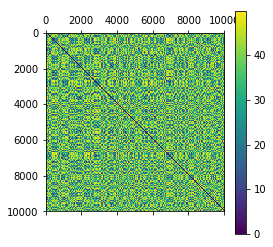

In [8]:
# Display Unsorted Distances
plt.matshow(unsorted_dist)
plt.colorbar()
plt.show()

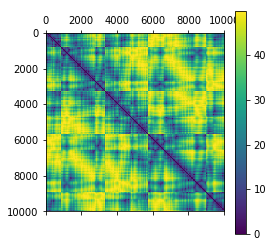

In [9]:
# Display Sorted Distances
plt.matshow(sorted_dist)
plt.colorbar()
plt.show()

Look how points have clustered, with distances between close neighboring points along the sequence having darker color indicating that they are close to one another in 3D space. For fun, change the number of `bins` to 16 or 64 and notice the difference as the order of the curve increases. Also, increase the number of points and see how the increasing the order of the curve helps better order larger clouds. 

### Experiment 1: Sequence-based Average Pooling
The purpose of this sorting algorithm is to establish an ordering on unstructured point cloud data. Currently in deep learning, there is a push to work with point cloud data, but many approaches are currently having trouble of effective applying pooling operations to unstructured data. In addition, many proposed solutions are very expensive to run such as attention-based pooling. Here, we propose using HilbertSort to order 3D pointclouds which will then allow us to apply 1D pooling operations which are fast and already implemented in many NN libraries.

In [10]:
import torch
import torch.nn.functional as tfnn
from scipy.spatial.distance import directed_hausdorff

In [11]:
# Pytorch Tensors
torch_data = torch.from_numpy(np.expand_dims(np.transpose(data, (1,0)),axis=0))
torch_sorted_data = torch.from_numpy(np.expand_dims(np.transpose(sorted_data, (1,0)),axis=0))

In [12]:
# Apply 1D Average Pooling to Un-Sorted Data
pooled_unsorted = np.transpose(tfnn.avg_pool1d(torch_data, kernel_size).numpy()[0], (1,0))
print("Pooled Un-Sorted:\n", pooled_unsorted)

Pooled Un-Sorted:
 [[ 3.4754677   1.9272806  -0.08012668]
 [-7.1615769  -0.99782862 -1.62613301]
 [ 0.86167473  8.24887305  3.00637803]
 ...
 [-1.26123439 10.30412643  2.2835011 ]
 [-3.88961499 -0.40964637  1.84442664]
 [ 1.36040581  1.86062052 -0.74397695]]


In [13]:
# Apply 1D Average Pooling to Sorted Data
pooled_sorted = np.transpose(tfnn.avg_pool1d(torch_sorted_data, kernel_size).numpy()[0], (1,0))
print("Pooled Sorted:\n", pooled_sorted)

Pooled Sorted:
 [[ -7.60446519 -23.35968029  -4.47259498]
 [ -8.08658379 -22.55637221  -6.99128914]
 [ -7.31516223 -22.40288904  -8.22849484]
 ...
 [ -7.6885248  -23.68633499   0.1184494 ]
 [ -7.80201516 -23.64584396  -0.1991662 ]
 [ -7.92099633 -23.62448139  -0.60771663]]


In [14]:
# Calculate Pairwise Distances
pooled_unsorted_ = sorter.sort(pooled_unsorted)
pooled_unsorted_dist = distance_matrix(pooled_unsorted_, pooled_unsorted_)
pooled_sorted_dist = distance_matrix(pooled_sorted, pooled_sorted)

# Normalize Distances
pooled_unsorted_dist = pooled_unsorted_dist 
pooled_sorted_dist = pooled_sorted_dist 

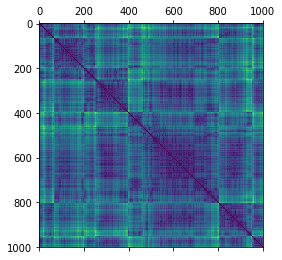

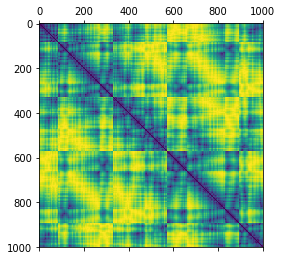

In [15]:
# Display Pooled Unsorted Distances
plt.matshow(pooled_unsorted_dist)
plt.matshow(pooled_sorted_dist)
plt.show()

In the images above, the distances for the unsorted and sorted pooled points. The unsorted pooled points have been sorted after pooling for comparison purposes. Here, we see that the set of coordiantes that were sorted prior to pooling (bottom image) resembles the original distance matrix much more than those without the sorting (top image). The following section shows the pooled objects in 3D as well as provide a metric to measure similarity between pooled and unpooled points for both sorted and unsorted cases.

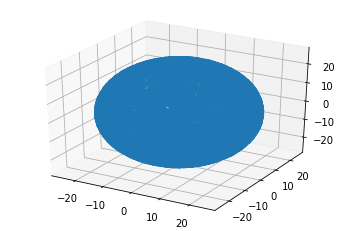

In [16]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(sorted_data[:,0], sorted_data[:,1], sorted_data[:,2], cmap='Greens');

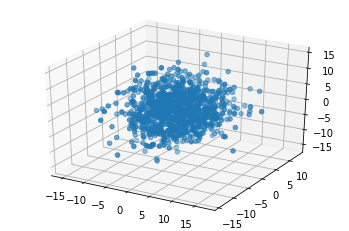

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pooled_unsorted[:,0], pooled_unsorted[:,1], pooled_unsorted[:,2], cmap='Greens');

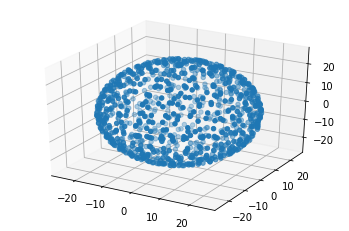

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pooled_sorted[:,0], pooled_sorted[:,1], pooled_sorted[:,2], cmap='Greens');

In [19]:
# Hausdorff distance between unpooled and pooled for sorted and unsorted
print("Un-Sorted Hausdorff Distance:", directed_hausdorff(data, pooled_unsorted)[0])
print("Sorted Hausdorff Distance:", directed_hausdorff(sorted_data, pooled_sorted)[0])

Un-Sorted Hausdorff Distance: 14.36296375346886
Sorted Hausdorff Distance: 3.4597913670948657


### Conclusion
As we can see, the Hilbert Sort provides substantial improvement over random averaging. It is able to maintain the global structure of the object as a result of the imposed ordering of nodes. Feel free to change any parameters at the top of the notebook to test out any configuration and to execute click `Kernel/Restart&RunAll`.